# 11. Machine Learning - Predicción de alza de activo

In [ ]:
!pip install TA-Lib backtrader quantstats --quiet

In [ ]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
import yfinance as yf
import talib

In [ ]:
df = yf.download("AAPL", start = "2021-01-01", end = "2025-10-31", auto_adjust=True, multi_level_index=False)
df.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2021-01-04,125.974464,130.062961,123.394814,129.975354,143301900
2021-01-05,127.531990,128.242621,125.020481,125.468276,97664900
2021-01-06,123.239075,127.570942,123.024914,124.329344,155088000
2021-01-07,127.444405,128.135562,124.465642,124.952368,109578200
2021-01-08,128.544357,129.108961,126.772667,128.914259,105158200


In [ ]:
df.shape

(1213, 5)

<Axes: xlabel='Date'>

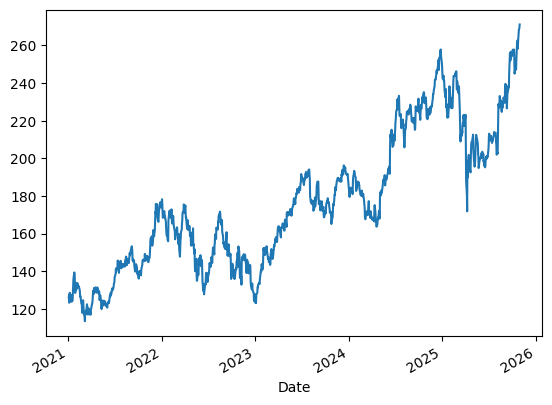

In [ ]:
df['Close'].plot()

## Feature engineering

In [ ]:
# Features

df["sma7"] = talib.SMA(df["Close"], timeperiod = 7)
df["sma21"] = talib.SMA(df["Close"], timeperiod = 21)

df["RSI"] = talib.RSI(df["Close"])

df["MACD"], df["MACDSignal"], df["MACDHist"] = talib.MACD(df["Close"],
                                                          fastperiod = 12,
                                                          slowperiod = 26,
                                                          signalperiod = 9)

df["ema12"] = talib.EMA(df["Close"], timeperiod=12)
df["ema26"] = talib.EMA(df["Close"], timeperiod=26)

In [ ]:
df["ret"] = df["Close"].pct_change()
df['Weekly_Change'] = df['Close'].pct_change(5)
df['target'] = (df['Weekly_Change'].shift(-1) > 0.01).astype(int)

features = ['Close','ret', 'Volume', 'sma7', 'sma21', 'RSI', 'MACD', 'MACDSignal', 'MACDHist', 'ema12', 'ema26']
df.dropna(inplace=True)


<Axes: xlabel='Date'>

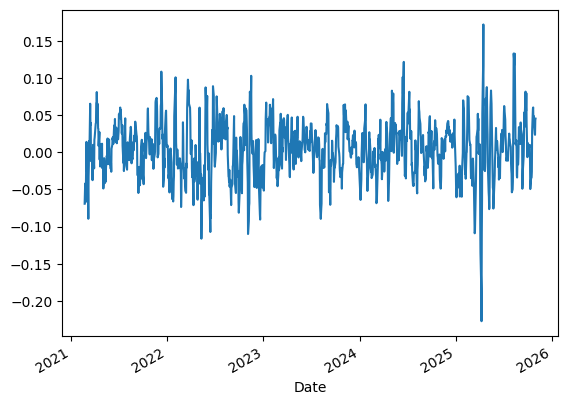

In [ ]:
df['Weekly_Change'].plot()

Class distribution of the 'target' variable:
target
0    649
1    531
Name: count, dtype: int64


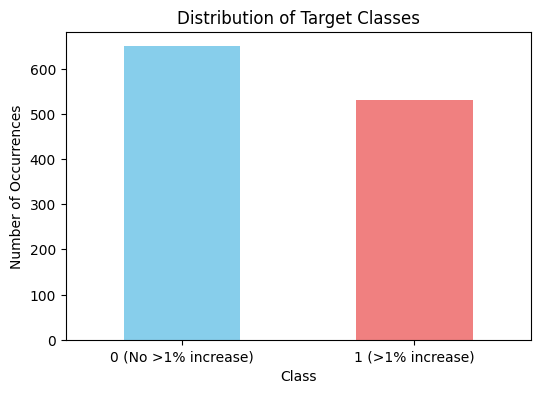

In [ ]:
class_counts = df['target'].value_counts()

print("Class distribution of the 'target' variable:")
print(class_counts)

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of Target Classes')
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.xticks(ticks=[0, 1], labels=['0 (No >1% increase)', '1 (>1% increase)'], rotation=0)
plt.show()


Separar en entrenamiento y prueba

In [ ]:
split_index = int(len(df) * 0.8)

X_train = df[features].iloc[:split_index]
y_train = df['target'].iloc[:split_index]
X_test = df[features].iloc[split_index:]
y_test = df['target'].iloc[split_index:]

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (944, 11)
Shape of y_train: (944,)
Shape of X_test: (236, 11)
Shape of y_test: (236,)


Entrenar modelo

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Evaluar modelo

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

Accuracy: 0.7119
Precision: 0.7333
Recall: 0.6581
F1-Score: 0.6937


Feature importance

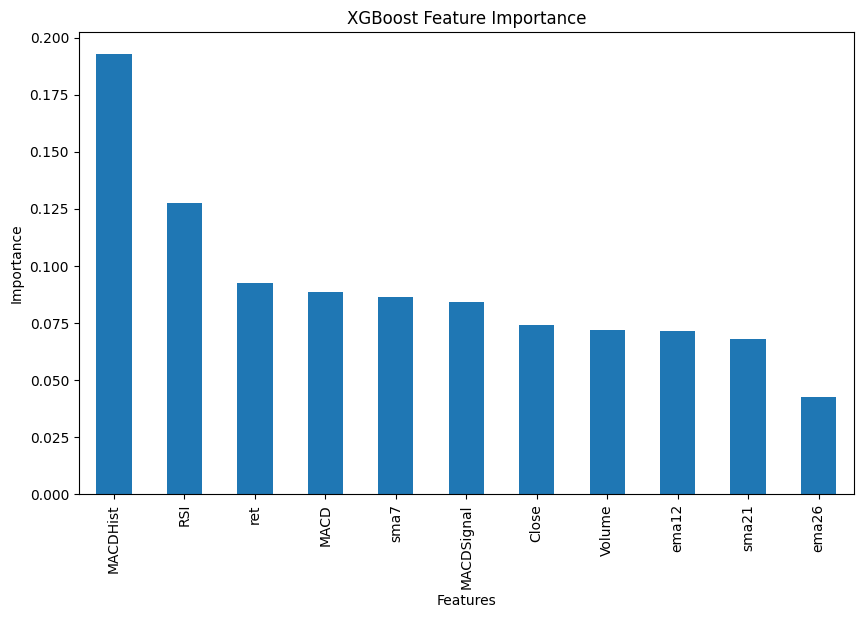

In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances_sorted.plot(kind='bar')
plt.title('XGBoost Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

## Comparar estrategia vs buy-and-hold

In [ ]:
X_test['pred'] = y_pred

In [ ]:
X_test['pred'].values

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1])

In [ ]:
X_test["ret_est"]=X_test["pred"].shift(1) * X_test["ret"]

In [ ]:
import quantstats as qs

rf = .04
qs.reports.metrics(X_test["ret_est"], benchmark = X_test['ret'], rf = rf, mode = "full")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-11-21   2024-11-21
End Period                 2025-10-30   2025-10-30
Risk-Free Rate             4.0%         4.0%
Time in Market             100.0%       44.0%

Cumulative Return          19.19%       33.26%
CAGR﹪                     20.71%       36.06%

Sharpe                     0.61         1.5
Prob. Sharpe Ratio         53.61%       82.81%
Smart Sharpe               0.58         1.43
Sortino                    0.92         2.18
Smart Sortino              0.88         2.09
Sortino/√2                 0.65         1.54
Smart Sortino/√2           0.62         1.48
Omega                      1.54         1.54

Max Drawdown               -33.36%      -15.28%
Max DD Date                2025-04-08   2025-04-21
Max DD Period Start        2024-12-27   2025-04-03
Max DD Period End          2025-10-17   2025-05-12
Longest DD Days            295          49
Volati